### HDDM Exmple (Ostwald's data)
This is the script for the drift diffusion model analysis for exploring Ostwald's open behavioral data.

This dataset might be useful for later test for EEG-behavior-fMRI joint modeling

In [1]:
# check the current python version, make sure this is the one that with HDDM correctly installed
import sys
sys.executable

'/opt/conda/bin/python'

In [26]:
%matplotlib inline

# Preparation
import os, hddm, time, csv
import kabuki 
import datetime

# import the toolbox
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
import seaborn as sns

# set the color of plots
from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler(color='bgrcmykw')

In [3]:
# load data from cateogriztion based on moral valence
df = hddm.load_csv('df_behav_Ostwald.csv')

# check the head of the data

# flip the error RTs to be negative
# df = hddm.utils.flip_errors(df)

## Uncomment the codes below if you are interested in checking the distribution of raw data


## Visualization of the data

This dataset was based on a 2 by 2 within subject design, with factors stimulus coherence (low, high) and spatial prioritization (yes, no). 

Data are from 17 participants (8 female, mean age 25.9 yrs, rang 20 ~ 33, 2 left-handed) recruited from University of Birmingham. 

Original stimulus set include 18 pictures of cars and 18 pictures of faces. 

Procedure:

EEG experiment outside MRI scanner (72 trials/condition) --> EEG inside scanner (90 trials/condition)

### The way HDDM visualize data

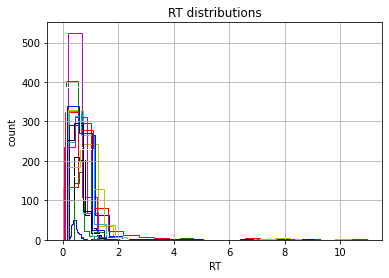

In [4]:
# plot and save the distribution of raw data:
fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='RT distributions')
for i, subj_data in df.groupby('subj_idx'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)
# plt.savefig('plot_df_behav_ostwald.pdf')

### Multiple ways to visualize the data in Python

#### First, visualize the summary data, as presented in the [preprint](https://www.biorxiv.org/content/10.1101/253047v1)

Basically, we get the summary (mean/median, and sd) of the RT for each condtion. Here, we demonstrated two ways to visualize the data: bar plots (with error bar) and raincloud plots.

Check the number of trials

In [5]:
df["cond"] = df["cue"] + "_" + df["coherence"]

# check the trials for accurate and wrong responses
df.groupby(['status', 'subj_idx', 'cond', 'accuracy']).size()

status   subj_idx  cond          accuracy
inside   2         invalid_high  0            3
                                 1           87
                   invalid_low   0           12
                                 1           75
                   valid_high    0            5
                                             ..
outside  17        invalid_low   1           56
                   valid_high    0            1
                                 1           71
                   valid_low     0           12
                                 1           60
Length: 247, dtype: int64

Replicate the Figure 2a in Georgie et al (2018). First, get the mean of each condition, then, plot the mean and SD (instead of SE in the manuscript).

But, the plot looks like a bit different to the Fig 2a in the preprint.

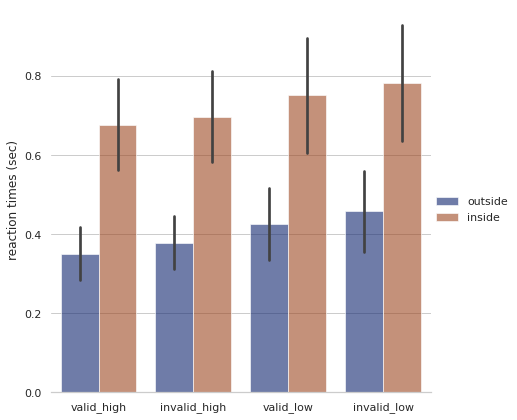

In [6]:
# get the median of accurate RTs
df_rt_sum = df[df['accuracy'] ==1].groupby(['subj_idx','status', 'cond'])['rt'].median().reset_index()

# categorize the cond and order the data
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['valid_high', 'invalid_high', 'valid_low', 'invalid_low'],
                           ordered=True)
df_rt_sum['cond'] = df_rt_sum['cond'].astype(cat_type)
# df_sum.head(20)

sns.set_theme(style="whitegrid")

# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_rt_sum, kind="bar",
    x="cond", y="rt", hue="status",
    ci="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "reaction times (sec)")
g.legend.set_title("")

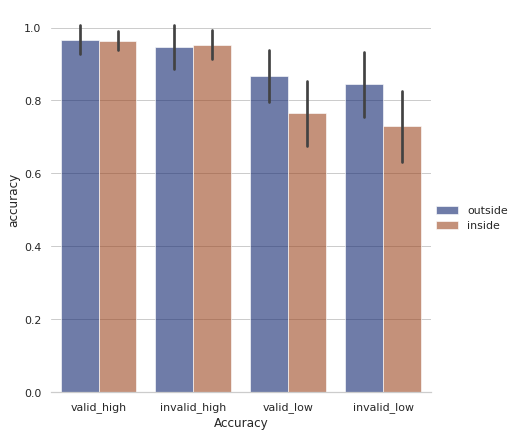

In [7]:
# get the median of accurate RTs
df_acc_sum = df.groupby(['subj_idx','status', 'cond'])['accuracy'].mean().reset_index()

# categorize the cond and order the data
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['valid_high', 'invalid_high', 'valid_low', 'invalid_low'],
                           ordered=True)
df_acc_sum['cond'] = df_acc_sum['cond'].astype(cat_type)
df_acc_sum.head(20)

sns.set_theme(style="whitegrid")

# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_acc_sum, kind="bar",
    x="cond", y="accuracy", hue="status",
    ci="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("Accuracy")
g.legend.set_title("")

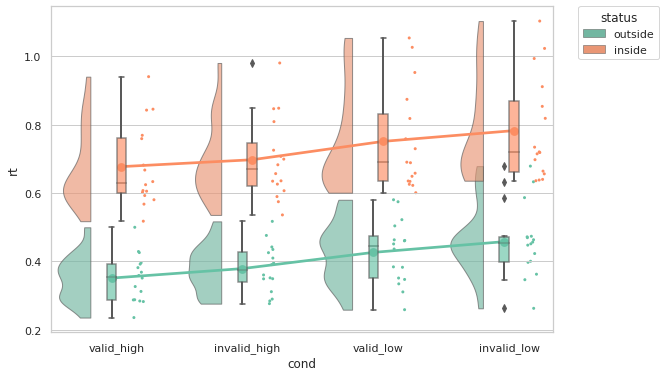

In [8]:
# plot raincloud of RT
import ptitprince as pt

dx = "cond"; dy = "rt"; dhue = "status"; ort = "v"; pal = "Set2"; sigma = .4

f, ax = plt.subplots(figsize=(9, 6))

ax = pt.RainCloud(x=dx, y=dy, hue=dhue, data=df_rt_sum, palette=pal, bw=sigma, width_viol=.5,
                 ax=ax, orient=ort, alpha=.65, dodge=True, pointplot=True, move=.2)

Plot individual data

In [9]:
df_p = df.set_index(['subj_idx'])
df_p.describe()

runid     condition   image_index          stim      response  \
count  10205.000000  10205.000000  10205.000000  10205.000000  10205.000000   
mean       2.326997      2.500441     36.362959      0.499461      0.524057   
std        1.333751      1.118571     20.778497      0.500024      0.499445   
min        1.000000      1.000000      1.000000      0.000000      0.000000   
25%        1.000000      1.000000     19.000000      0.000000      0.000000   
50%        2.000000      3.000000     37.000000      0.000000      1.000000   
75%        3.000000      4.000000     54.000000      1.000000      1.000000   
max        5.000000      4.000000     72.000000      1.000000      1.000000   

                 rt      accuracy  stimulus_side  
count  10205.000000  10205.000000   10205.000000  
mean       0.705192      0.877413       0.500735  
std        0.746310      0.327979       0.500024  
min        0.000117      0.000000       0.000000  
25%        0.413091      1.000000       0.000000  
50%        0.593741      1.000000       1.000000  
75%        0.772207      1.000000       1.000000  
max       10.953051      1.000000       1.000000

In [10]:
# import packages and function for interactive plotting
import chart_studio.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot,iplot_mpl
from plotly.graph_objs import *
import cufflinks as cf
init_notebook_mode(connected=True)

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [11]:
@interact(index_name=df_p.index.unique())
def iplot_scale(index_name):
    df_tmp = df_p[df_p.index==index_name]['rt']
    iplot(df_tmp.iplot(asFigure=True,kind='histogram', bins = 20,subplots=True, shape=(1, 1), filename='histogram-subplots'))

interactive(children=(Dropdown(description='index_name', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1…

## Traditional analyses

Maybe we can add some classic analysis using `pymc3` and [`bambi`](https://github.com/bambinos/bambi).

We can try signal detection theory to model accuracy and `shifted log normal` to model RTs.

In [12]:
import bambi as bmb
import numpy as np
import pandas as pd

# check whether bambi works
data = pd.DataFrame({
    "y": np.random.normal(size=50),
    "g": np.random.choice(["Yes", "No"], size=50),
    "x1": np.random.normal(size=50),
    "x2": np.random.normal(size=50)
})

In [13]:
# Test the bambi package
model = bmb.Model(data)
fitted = model.fit("y ~ x1 + x2")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_sigma, x2, x1, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5ff8f41990>,
      dtype=object)

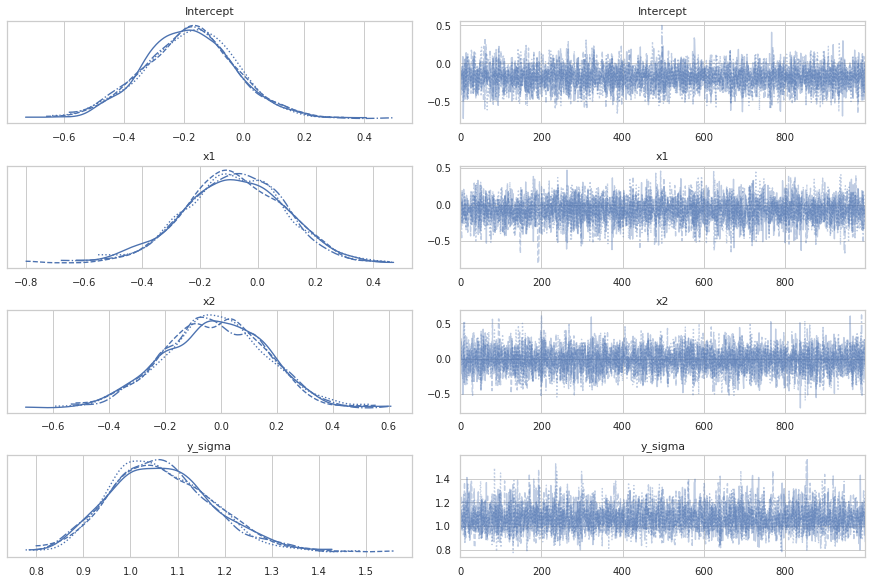

In [14]:
import arviz as az
az.plot_trace(fitted)

In [15]:
az.summary(fitted)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept -0.182  0.152  -0.490    0.089      0.002    0.002    5778.0   
x1        -0.081  0.173  -0.409    0.236      0.002    0.003    5643.0   
x2        -0.022  0.180  -0.369    0.296      0.002    0.003    6207.0   
y_sigma    1.067  0.110   0.875    1.277      0.002    0.001    4547.0   

           ess_tail  r_hat  
Intercept    3256.0    1.0  
x1           3249.0    1.0  
x2           2910.0    1.0  
y_sigma      2932.0    1.0

## HDDM analyses

Now, we will start to use HDDM to model the data.

#### Model 1: HDDM

We will model the data as if the data are between-subject design (i.e., treat different condition as independent). We will use the function `HDDM` to model the data. 

Also, we will include all parameter in the model.

In [23]:
# define a function to run model in parallel
def run_model(id):
    print('running model%i'%id);
    
    import hddm
    import random
    #import os
    
    #cur_dir = os.getcwd()

    exp_name = 'Ostwald'
    model_tag = 'vatz'
    print('running models %i'%id, 'for ', exp_name)
    
    # USE the absolute directory in docker.
    dbname = '/home/jovyan/hddm/tutorial/df_' + exp_name + model_tag + '_chain_%i.db'%id # define the database name, which uses pickle format
    mname  = '/home/jovyan/hddm/tutorial/df_' + exp_name + model_tag + '_chain_%i'%id    # define the name for the model
    fname  = '/home/jovyan/hddm/tutorial/df_' + exp_name + '.csv'
    df = hddm.load_csv(fname)
    
    m = hddm.HDDM(df,
                  include= ['v', 'a', 't', 'z'],
               depends_on={'v':['status','cue','coherence'], 
                           'a':['status','cue','coherence'],
                           't':['status','cue','coherence'], 
                           'z':['status','cue','coherence']},
               p_outlier = .05)
    m.find_starting_values()
    m.sample(3000, burn=1000, dbname=dbname, db='pickle')
    m.save(mname)
    
    return m

In [24]:
from ipyparallel import Client

v = Client()[:]

start_time = time.time()  # the start time of the processing

jobs = v.map(run_model, range(4)) # 4 is the number of CPUs
models = jobs.get()

print("\nRunning 4 chains used: %f seconds." % (time.time() - start_time))


Running 4 chains used: 1591.403720 seconds.


In [27]:
M1_models = []
for id in range(4):
    mname = 'df_Ostwaldvatz_chain_%i'%id   # print('\nProcessing Model ', i)
    m_tmp = hddm.load(mname)
    M1_models.append(m_tmp)

# Create a new model that has all traces concatenated of individual models.
M1_models_comb = kabuki.utils.concat_models(M1_models)

In [28]:
M1_R_hat_vtaz = hddm.analyze.gelman_rubin(M1_models) # get the R hat information
# M1_R_hat_vtz

# save Categ_R_hat_vtz
with open('M1_R_hat_vtaz.csv','w') as f:
    w = csv.writer(f)
    w.writerows(M1_R_hat_vtaz.items())

In [46]:
def plot_grp_trace(models, param):
    import seaborn as sns
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    
    df_grp_traces = []
    for i in range(4):
        df_m = models[i]
        df_grp_trace = df_m.get_group_traces()
        df_grp_trace['chain'] = i
        print('chain', i, df_grp_trace.shape)
        df_grp_traces.append(df_grp_trace)
    df_grp_traces = pd.concat(df_grp_traces)
    
    # select the columns included that parameter
    filter_col = [col for col in df_grp_traces if col.startswith(param)]
    filter_col.append('chain') # add the chain column to the data
    
    #df_tmp = df_grp_traces[df_grp_traces.columns.intersection(filter_col)]
    df_tmp = df_grp_traces.loc[:,filter_col]
    df_tmp["sample_id"] = df_tmp.index
    
    df_melt = pd.melt(df_tmp,
                      id_vars=['sample_id', 'chain'],
                      value_vars=filter_col[:-1],
                      var_name='cond',
                      value_name='value')
    
    sns.set_palette("Set2")
    for indx, df_tmp in df_melt.groupby('cond'):

        fig, axs = plt.subplots(ncols=2,figsize=(20, 9))
        print(indx)

        sns.lineplot(x='sample_id', y='value', hue="chain", data=df_tmp, ax=axs[0], palette='Set2')
        
        sns.kdeplot(data=df_tmp, x="value", hue="chain", ax=axs[1], palette='Set2',
                    shade=False, linewidth=3)

#         sns.distplot(df_tmp.loc[df_tmp['chain'] == 0, 'value'], hist = False, kde = True,
#                          kde_kws = {'shade': False, 'linewidth': 3},ax=axs[1], label = '0')
#         sns.distplot(df_tmp.loc[df_tmp['chain'] == 1, 'value'], hist = False, kde = True,
#                          kde_kws = {'shade': False, 'linewidth': 3},ax=axs[1], label = '1')
#         sns.distplot(df_tmp.loc[df_tmp['chain'] == 2, 'value'], hist = False, kde = True,
#                          kde_kws = {'shade': False, 'linewidth': 3},ax=axs[1], label = '2')
#         sns.distplot(df_tmp.loc[df_tmp['chain'] == 3, 'value'], hist = False, kde = True,
#                          kde_kws = {'shade': False, 'linewidth': 3},ax=axs[1], label = '3')

        #axs[0].set_ylim([0.5, 3])
        axs[0].set_title(indx, fontsize=20)
        #axs[1].set_xlim([0.5, 3])
        axs[1].set_title(indx, fontsize=20)
        plt.show()

chain 0 (2000, 37)
chain 1 (2000, 37)
chain 2 (2000, 37)
chain 3 (2000, 37)
v(high.invalid.inside)


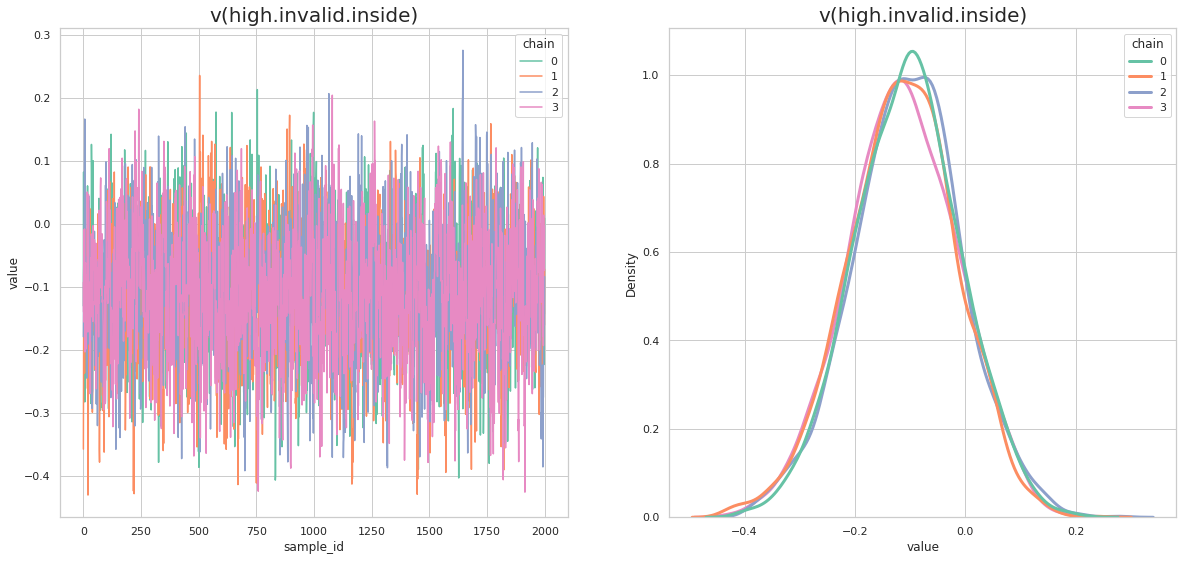

v(high.invalid.outside)


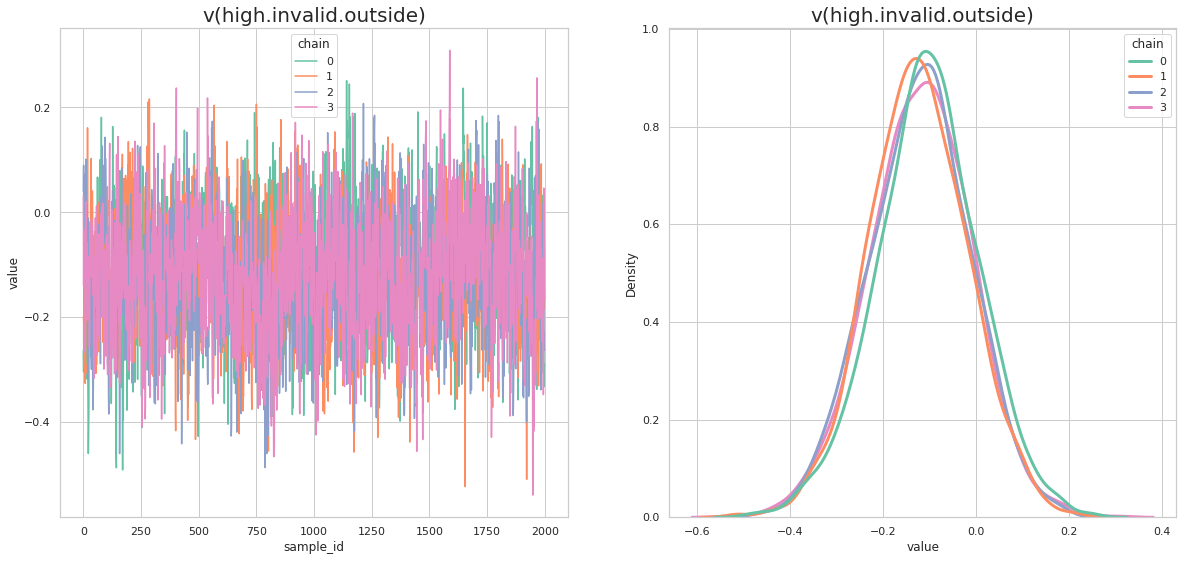

v(high.valid.inside)


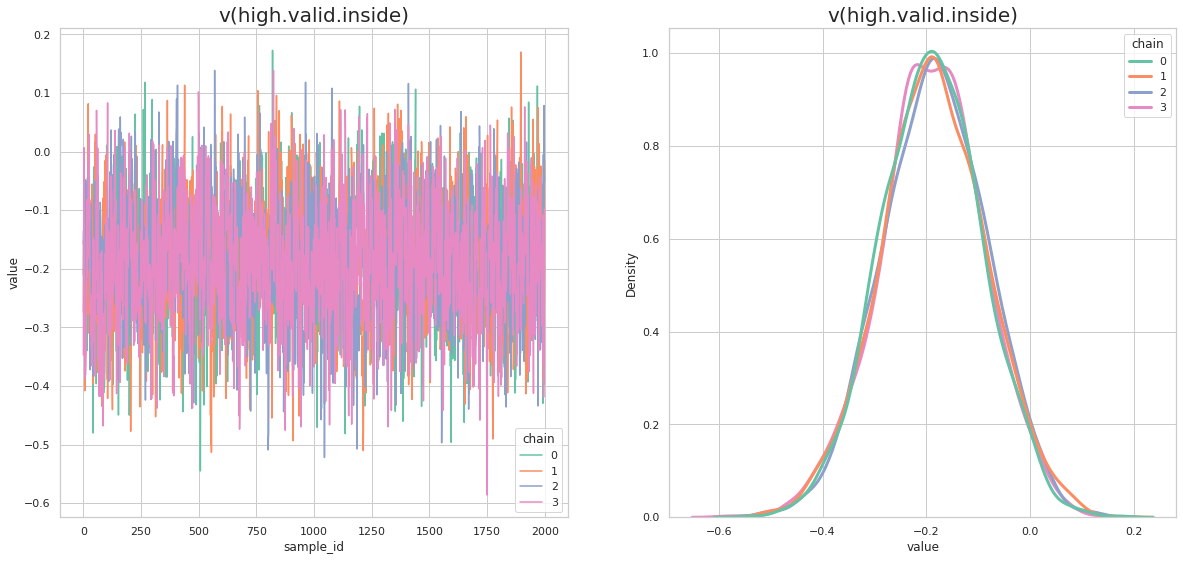

v(high.valid.outside)


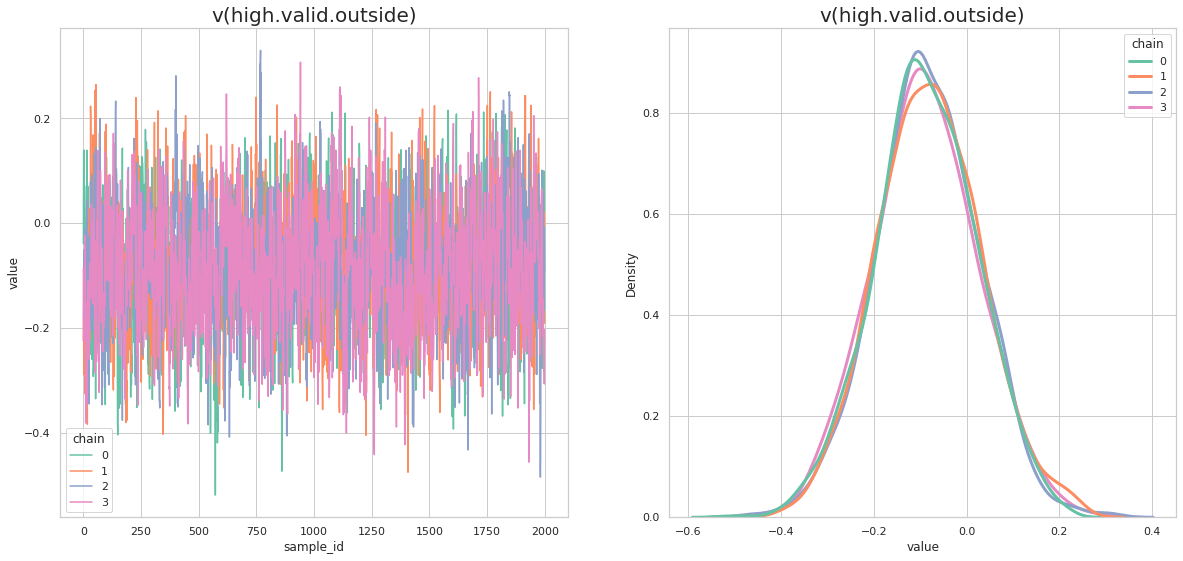

v(low.invalid.inside)


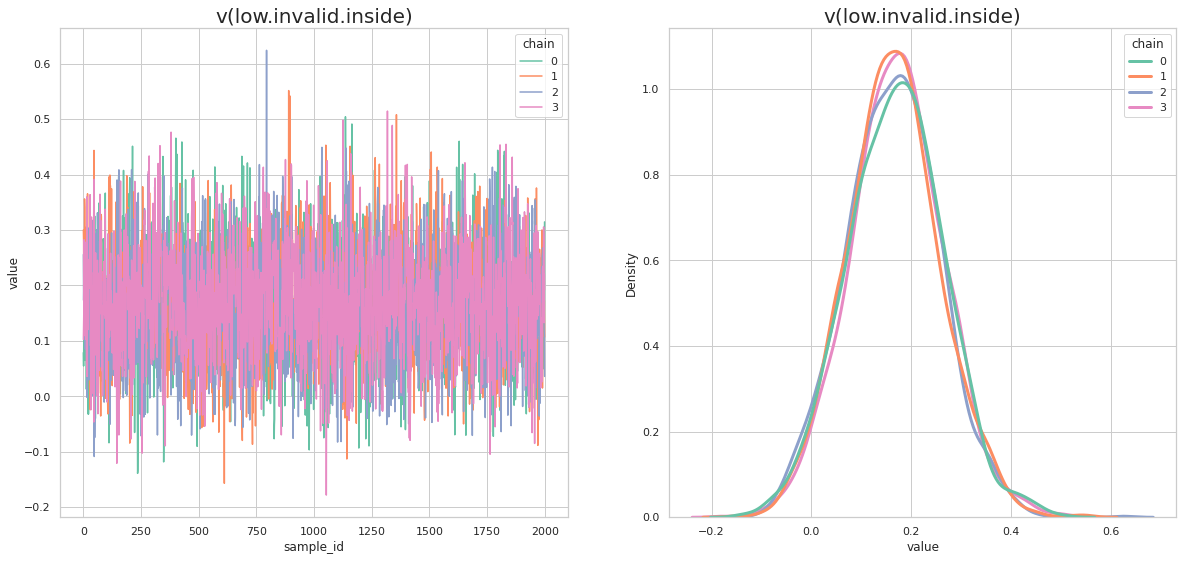

v(low.invalid.outside)


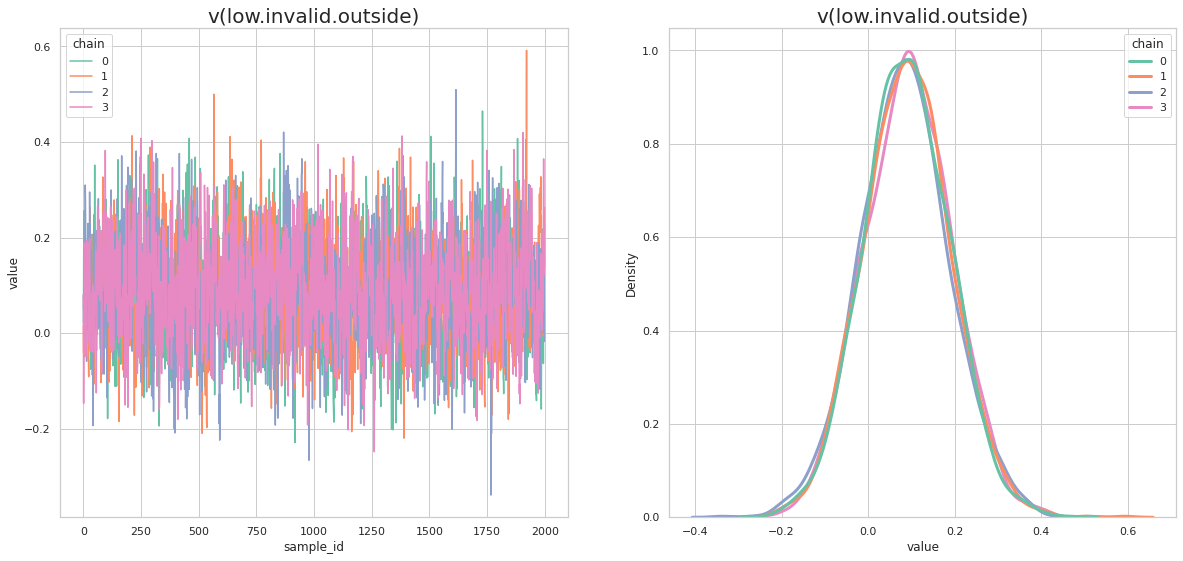

v(low.valid.inside)


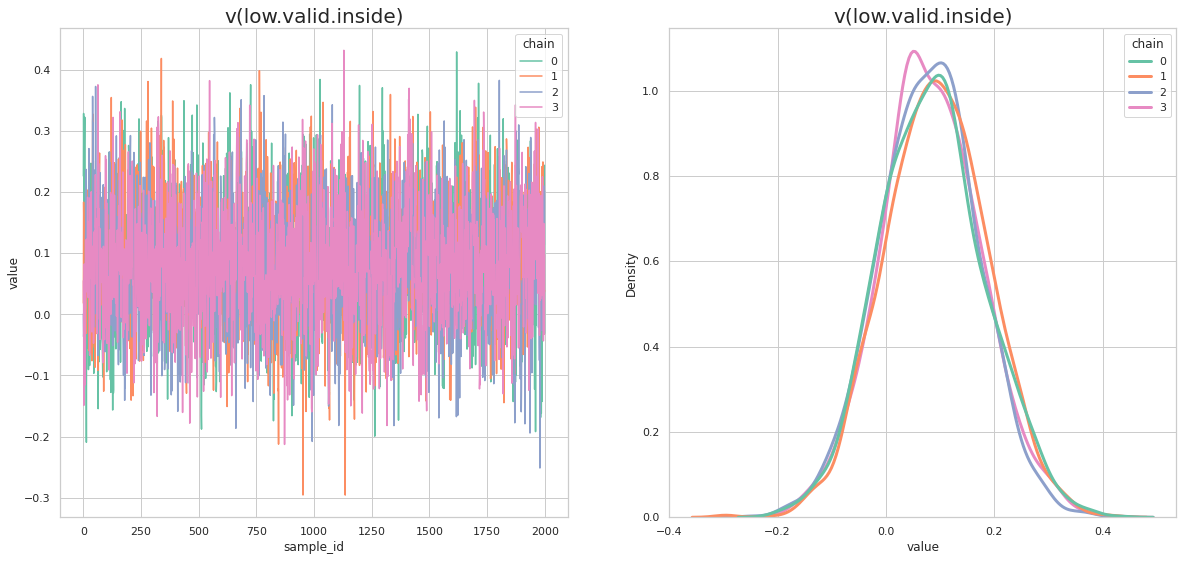

v(low.valid.outside)


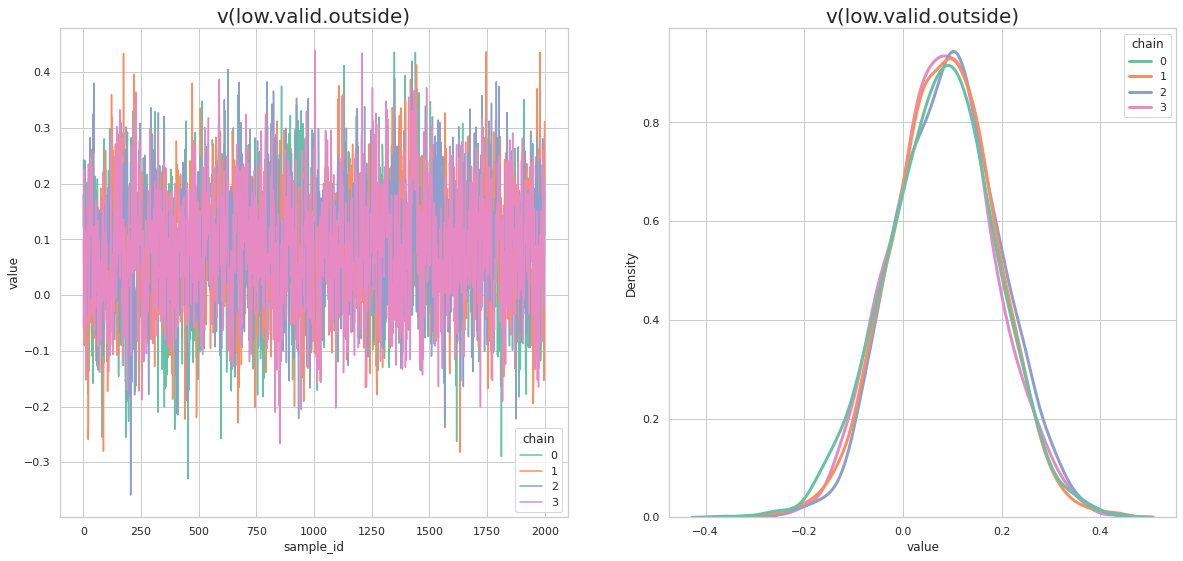

v_std


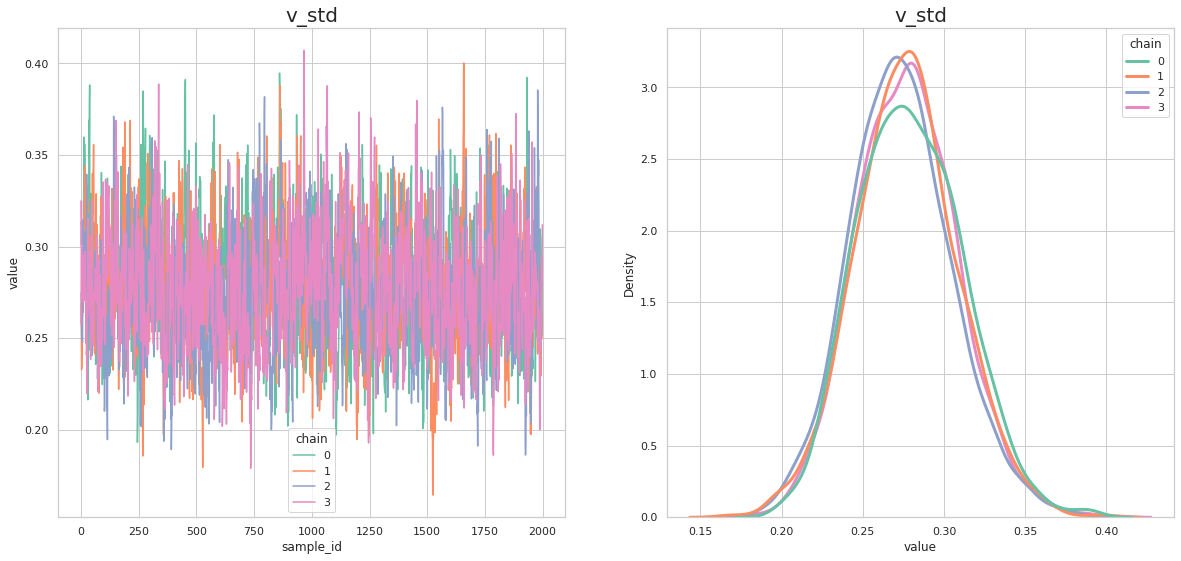

In [47]:
plot_grp_trace(models=M1_models, param='v')

In [16]:
df.head()

subj_idx   status  runid  condition      cue coherence  image_index  stim  \
0         1  outside      1          1    valid      high           19     1   
1         1  outside      1          2  invalid      high           12     0   
2         1  outside      1          2  invalid      high           20     1   
3         1  outside      1          1    valid      high            5     0   
4         1  outside      1          1    valid      high           13     0   

   response        rt  accuracy  stimulus_side          cond  
0         1  0.529206         1              0    valid_high  
1         0  0.519501         1              0  invalid_high  
2         1  0.611204         1              0  invalid_high  
3         0  0.465089         1              0    valid_high  
4         0  0.367166         1              1    valid_high

In [16]:
nsample = 3000     # number of sampling
nburn   = 1000      # number of burn

# dateToday = str(date.today())  # replace the code below if you prefer using the actual date
dateToday = '1st' # using final in the saved file name
dbname = "M" + dateToday

In [18]:
start_time = time.time()  # the start time of the processing
 
import warnings           # suppress the warnings
warnings.simplefilter('ignore')


M1 = hddm.HDDM(df,
               include= ['v', 'a', 't', 'z'],
               depends_on={'v':['status','cue','coherence'], 
                           'a':['status','cue','coherence'],
                           't':['status','cue','coherence'], 
                           'z':['status','cue','coherence']},
               p_outlier = .05)

M1.find_starting_values()

M1.sample(nsample, burn=nburn, dbname=dbname + '.db', db='pickle')
   
# save the model
M1.save(dbname)

## print the time used for modelling
m1_time = time.time() # the time when the script runs to here

print("Running M1 used: %f seconds" % (m1_time - start_time))

## print DIC
print("M1 DIC: %f" % M1.dic)  #

 [-----------------100%-----------------] 3001 of 3000 complete in 1402.7 secRunning M1 used: 1463.150335 seconds
M1 DIC: 7274.296283


In [17]:
M1 = hddm.load(dbname) # if you already saved the model, you can load it with this code.

In [18]:
df_grp_trace = M1.get_group_traces()
df_grp_trace['chain'] = 0
df_grp_trace.shape

(2800, 37)

In [19]:
import re

lst = ["v(", "a(", "t("]
esc_lst = [re.escape(s) for s in lst]
pattern = '|'.join(esc_lst)

# select v, a, t, and chains
slct_columns = df_grp_trace.columns[df_grp_trace.columns.str.contains(pattern, case=False)]

df_tmp = df_grp_trace[slct_columns]
df_tmp

a(high.invalid.inside)  a(high.invalid.outside)  a(high.valid.inside)  \
0                   1.036931                 0.962352              0.981257   
1                   0.968745                 0.959067              0.972554   
2                   1.007444                 0.963750              0.964294   
3                   1.045784                 0.915629              1.059351   
4                   1.043479                 0.973366              0.956787   
...                      ...                      ...                   ...   
2795                1.003797                 0.919552              0.964297   
2796                1.004279                 0.934599              0.933137   
2797                1.014548                 0.955848              1.060987   
2798                0.998329                 0.955857              0.974501   
2799                0.944222                 0.859925              1.000394   

      a(high.valid.outside)  a(low.invalid.inside)  a(low.invalid.outside)  \
0                  0.867054               1.135549                1.096656   
1                  0.897855               1.160286                1.092716   
2                  0.860492               1.212329                1.113053   
3                  0.877345               1.207164                1.160105   
4                  0.879853               1.217088                1.001517   
...                     ...                    ...                     ...   
2795               0.932883               1.184623                1.061393   
2796               0.853148               1.231056                1.051616   
2797               0.938782               1.239663                1.069514   
2798               0.927674               1.214158                1.028808   
2799               0.892878               1.225101                1.087397   

      a(low.valid.inside)  a(low.valid.outside)  v(high.invalid.inside)  \
0                1.223857              1.085830               -0.194897   
1                1.132322              1.068549               -0.181508   
2                1.136683              0.998974               -0.199985   
3                1.249180              1.075768               -0.084812   
4                1.166649              1.060736               -0.131501   
...                   ...                   ...                     ...   
2795             1.208211              1.104024               -0.183652   
2796             1.232774              0.967756               -0.149000   
2797             1.211280              1.030995               -0.128416   
2798             1.150099              1.022288               -0.161640   
2799             1.149493              1.014174               -0.141796   

      v(high.invalid.outside)  ...  v(low.valid.inside)  v(low.valid.outside)  \
0                   -0.286946  ...             0.138370              0.219059   
1                   -0.176863  ...             0.023634              0.267732   
2                   -0.181856  ...             0.074698              0.139440   
3                   -0.281927  ...             0.047830              0.054352   
4                   -0.185161  ...             0.308414             -0.048128   
...                       ...  ...                  ...                   ...   
2795                -0.029912  ...             0.060340              0.067567   
2796                -0.095541  ...             0.137945              0.010213   
2797                -0.248947  ...             0.094439             -0.061782   
2798                -0.072115  ...             0.072778             -0.069647   
2799                -0.158362  ...             0.143886             -0.112907   

      t(high.invalid.inside)  t(high.invalid.outside)  t(high.valid.inside)  \
0                   0.479035                 0.200448              0.456459   
1                   0.469451                 0.189116              0.486732   
2        

In [20]:
df_tmp["id"] = df_tmp.index
# df_tmp.head()
print('Shape of the wide format', df_tmp.shape)

df_melt = pd.melt(df_tmp,
                  id_vars=['id', 'chain'],
                  value_vars=slct_columns[:-1],
                  var_name='cond',
                  value_name='value')

#type(df_melt)
print('Shape of the long format', df_melt.shape)
df_melt.head()

Shape of the wide format (2800, 25)


KeyError: "The following 'id_vars' are not present in the DataFrame: ['chain']"

In [11]:
# split the cond column into three columns

df_melt[['params','coherence','cue','status']] = pd.DataFrame(df_melt['cond'].apply(lambda x: [i for i in re.split(r'[\(\)\.]', x) if len(i)>0]).to_list())


In [10]:

# df_melt.head()

# change the 'cond' column
df_melt['cond'] = df_melt[['Matchness', 'Valence']].apply(lambda x: '_'.join(x), axis=1)
# df_melt.head(10)

# long-to-wide to plot pair-plot
tmp = df_melt
tmp['idx'] = np.tile(np.arange(0, df_melt.shape[0]/3), 3)
tmp = df_melt.pivot_table(index=['idx', 'Matchness', 'Valence', 'cond'], columns='params', values='value').reset_index()
#tmp = df_melt.pivot(index='idx', columns='params', values='value')

print(tmp.shape)
# tmp.head()

ValueError: Columns must be same length as key

v(high.invalid.inside)  v(high.invalid.outside)  v(high.valid.inside)  \
0                   2.448680                 2.806875              2.806716   
1                   2.336532                 2.730557              2.888763   
2                   2.279391                 2.968125              2.437985   
3                   2.664177                 2.617920              2.982518   
4                   2.663445                 2.921772              2.901848   
...                      ...                      ...                   ...   
8995                2.653537                 2.693625              2.813534   
8996                2.702876                 2.906733              2.484725   
8997                2.396425                 2.897663              2.544756   
8998                2.304917                 2.655905              2.385945   
8999                2.507830                 2.572465              2.422508   

      v(high.valid.outside)  v(low.invalid.inside)  v(low.invalid.outside)  \
0                  2.894220               1.091365                1.653491   
1                  2.891293               1.078666                1.590468   
2                  2.862628               0.615956                1.684060   
3                  2.541084               0.782666                1.694769   
4                  2.923423               0.694825                1.482003   
...                     ...                    ...                     ...   
8995               2.674828               1.244089                1.863571   
8996               2.858649               1.001701                1.991898   
8997               3.089151               0.780472                1.834482   
8998               3.369869               0.706979                1.867567   
8999               2.895241               1.494679                1.723352   

      v(low.valid.inside)  v(low.valid.outside)  t(high.invalid.inside)  \
0                1.377813              1.924445                0.489088   
1                1.509509              2.260636                0.476282   
2                1.236967              2.089604                0.481046   
3                1.065067              2.207131                0.472109   
4                1.275899              1.827823                0.469825   
...                   ...                   ...                     ...   
8995             1.455988              2.282276                0.491799   
8996             1.011933              2.259224                0.455707   
8997             1.014406              1.642480                0.478242   
8998             1.149930              1.890334                0.472175   
8999             1.236203              1.501336                0.469655   

      t(high.invalid.outside)  t(high.valid.inside)  t(high.valid.outside)  \
0                    0.175026              0.469935               0.169559   
1                    0.214326              0.440999               0.179517   
2                    0.192587              0.466403               0.196443   
3                    0.187515              0.484439               0.182947   
4                    0.180797              0.441110               0.166094   
...                       ...                   ...                    ...   
8995                 0.185683              0.486197               0.186398   
8996                 0.209388              0.458828               0.173409   
8997                 0.187279              0.475737               0.206333   
8998                 0.197998              0.477092               0.178387   
8999                 0.192739              0.474708               0.207584   

      t(low.invalid.inside)  t(low.invalid.outside)  t(low.valid.inside)  \
0                  0.524590                0.189442             0.506718   
1                  0.484637                0.173055             0.495251   
2                  0.532632                0.232407   

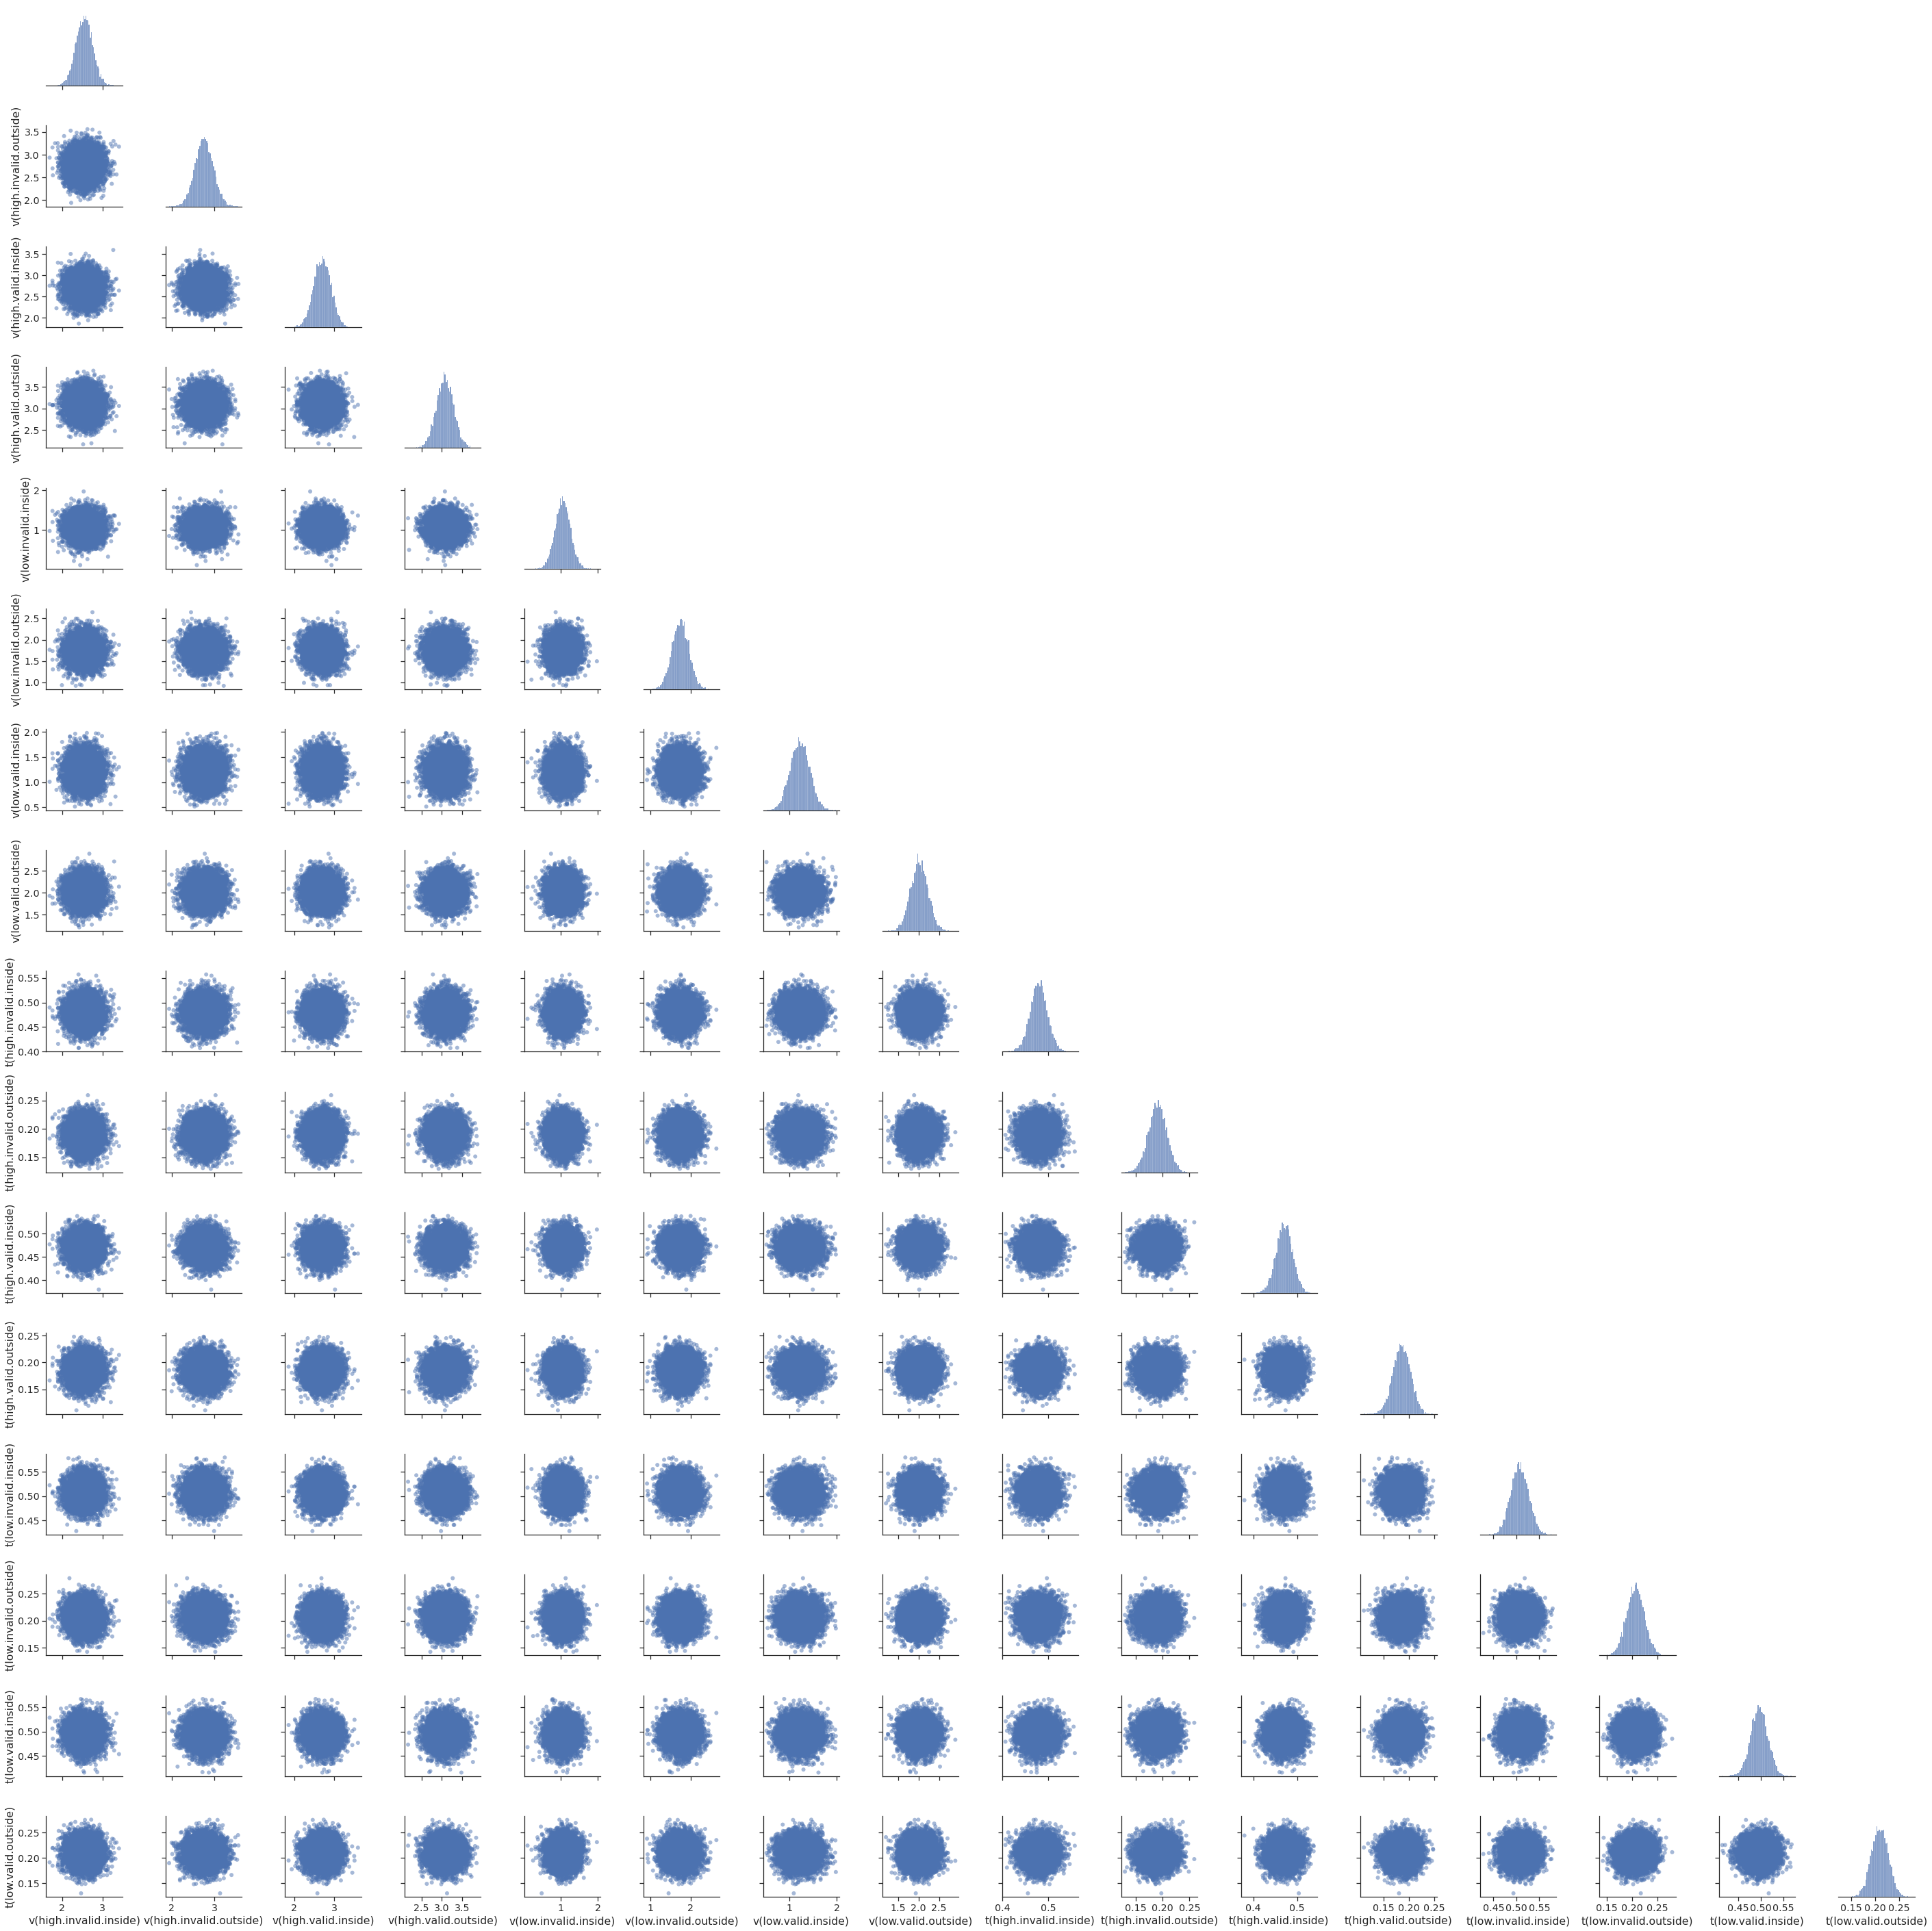

In [16]:
sns.set(style="ticks", color_codes=True, font_scale=1.3)

g = sns.pairplot(df_tmp, palette="bright", 
                 plot_kws=dict(edgecolor='none', alpha=0.5),
                 #height = 4, 
                 corner=True) # or linewidth=0
# plt.setp(g._legend.get_title(), fontsize=18)

In [10]:
m_stats = M1.gen_stats()
m_stats['params'] = m_stats.index
m_stats.head()


mean       std     2.5q      25q      50q  \
a(high.invalid.inside)   4.87085  0.318156  4.24451  4.66166  4.87598   
a(high.invalid.outside)  1.84546  0.207797  1.43966  1.70466   1.8459   
a(high.valid.inside)     5.07782  0.309129  4.44391  4.87304  5.08508   
a(high.valid.outside)    1.78556  0.199244  1.40188  1.65001  1.78074   
a(low.invalid.inside)    2.44463  0.250966  1.94602  2.27828  2.44432   

                             75q    97.5q      mc err                   params  
a(high.invalid.inside)   5.08739  5.50138  0.00796208   a(high.invalid.inside)  
a(high.invalid.outside)  1.98044  2.26195  0.00428506  a(high.invalid.outside)  
a(high.valid.inside)     5.28402  5.66106  0.00580671     a(high.valid.inside)  
a(high.valid.outside)    1.91759   2.1879  0.00460847    a(high.valid.outside)  
a(low.invalid.inside)    2.60926  2.94204  0.00457773    a(low.invalid.inside)

In [11]:
m_stats_subj = m_stats[m_stats['params'].str.contains("v_subj")]
m_stats_subj[['param','subj']] = m_stats_subj['params'].str.split("_",expand=True) 
m_stats_subj[['subj','conds','subj_idx']] = m_stats_subj['subj'].str.split("\(|\)",expand=True) 
m_stats_subj[['subj_idx']] = m_stats_subj['subj_idx'].str.split(".",expand=True)[1][:,np.newaxis]
#m_stats_subj[['coherence', 'cue', 'status']] = m_stats_subj['conds'].str.split(".",expand=True).loc[:,0:2]
m_stats_subj = m_stats_subj[['subj_idx', 'conds', 'param', 'mean']].copy()

m_stats_subj.head()



subj_idx                conds param     mean
v_subj(high.invalid.inside).2        2  high.invalid.inside     v  3.53341
v_subj(high.invalid.inside).3        3  high.invalid.inside     v  4.98348
v_subj(high.invalid.inside).4        4  high.invalid.inside     v  5.98156
v_subj(high.invalid.inside).5        5  high.invalid.inside     v  7.43326
v_subj(high.invalid.inside).6        6  high.invalid.inside     v  4.60577

In [12]:

m_stats_subj_wide = m_stats_subj.pivot_table(index=['subj_idx'], 
                                 columns=['param', 'conds'],
                                 aggfunc='first', 
                                 values = 'mean',     
                                 fill_value=0) 
#m1_stats_subj_wide.columns = m1_stats_subj_wide.columns.map('_'.join)
m_stats_subj_wide.reset_index(inplace=True)  

# reset the index
#m_stats_subj_wide.index = df_params.index

# change the data type of 'subj_idx'
m_stats_subj_wide['subj_idx'] = m_stats_subj_wide['subj_idx'].astype(int)
m_stats_subj_wide.columns = ['_'.join(col).strip() for col in m_stats_subj_wide.columns.values]

m_stats_subj_wide.head()

subj_idx_  v_high.invalid.inside  v_high.invalid.outside  \
0          1               0.000000                4.366877   
1         10               8.242080                2.585527   
2         11               3.696755                1.168598   
3         12               6.459364                4.135310   
4         13               5.626471                2.832245   

   v_high.valid.inside  v_high.valid.outside  v_low.invalid.inside  \
0             0.000000              3.237330              0.000000   
1             7.271292              4.536803              3.838258   
2             4.274861              2.175353              0.380342   
3             7.332550              4.215599              0.796895   
4             5.899269              3.113820              0.646277   

   v_low.invalid.outside  v_low.valid.inside  v_low.valid.outside  
0               4.375789            0.000000             3.788913  
1               1.927173            3.560574             2.641821  
2               0.401856            0.096920             0.737850  
3               1.995280            1.259812             2.975133  
4               1.593034            0.705816             1.386766

In [13]:
m_stats_subj_wide = m_stats_subj_wide.replace(0, np.nan)
m_stats_subj_wide.head()

subj_idx_  v_high.invalid.inside  v_high.invalid.outside  \
0          1                    NaN                4.366877   
1         10               8.242080                2.585527   
2         11               3.696755                1.168598   
3         12               6.459364                4.135310   
4         13               5.626471                2.832245   

   v_high.valid.inside  v_high.valid.outside  v_low.invalid.inside  \
0                  NaN              3.237330                   NaN   
1             7.271292              4.536803              3.838258   
2             4.274861              2.175353              0.380342   
3             7.332550              4.215599              0.796895   
4             5.899269              3.113820              0.646277   

   v_low.invalid.outside  v_low.valid.inside  v_low.valid.outside  
0               4.375789                 NaN             3.788913  
1               1.927173            3.560574             2.641821  
2               0.401856            0.096920             0.737850  
3               1.995280            1.259812             2.975133  
4               1.593034            0.705816             1.386766

In [14]:
p_m_stats_subj_wide = m_stats_subj_wide.drop(['subj_idx_'], axis = 1)
p_m_stats_subj_wide.head()

v_high.invalid.inside  v_high.invalid.outside  v_high.valid.inside  \
0                    NaN                4.366877                  NaN   
1               8.242080                2.585527             7.271292   
2               3.696755                1.168598             4.274861   
3               6.459364                4.135310             7.332550   
4               5.626471                2.832245             5.899269   

   v_high.valid.outside  v_low.invalid.inside  v_low.invalid.outside  \
0              3.237330                   NaN               4.375789   
1              4.536803              3.838258               1.927173   
2              2.175353              0.380342               0.401856   
3              4.215599              0.796895               1.995280   
4              3.113820              0.646277               1.593034   

   v_low.valid.inside  v_low.valid.outside  
0                 NaN             3.788913  
1            3.560574             2.641821  
2            0.096920             0.737850  
3            1.259812             2.975133  
4            0.705816             1.386766

In [15]:
# plt.matshow(.corr())
# plt.show()

corr = p_m_stats_subj_wide.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

In [30]:
m_stats_subj_wide.groupby(['coherence', 'cue', 'status'])[['v']].corr()

param                              v
coherence cue     status  param     
high      invalid inside  v      1.0
                  outside v      1.0
          valid   inside  v      1.0
                  outside v      1.0
low       invalid inside  v      1.0
                  outside v      1.0
          valid   inside  v      1.0
                  outside v      1.0

In [ ]:
def gen_params(m):
    '''
    A function get the individual's summarized parameter for later plotting and correlation analysis
    '''
    
    m_stats = m.gen_stats()
    m_stats['params'] = m_stats.index
    m_stats.head()

    m_stats_subj = m_stats[m_stats['params'].str.contains("v_subj")]
    
    ## split the strings to create a dataframe more friendly for plot
    m_stats_subj[['param','subj']] = m_stats_subj['params'].str.split("_",expand=True) 
    m_stats_subj[['subj','conds','subj_idx']] = m_stats_subj['subj'].str.split("\(|\)",expand=True) 

    # https://stackoverflow.com/questions/46124469/shape-mismatch-indexing-arrays-could-not-be-broadcast-together-with-shapes
    m_stats_subj[['subj_idx']] = m_stats_subj['subj_idx'].str.split(".",expand=True)[1][:,np.newaxis] 
    m_stats_subj[['StimType', 'condition']] = m_stats_subj['conds'].str.split(".",expand=True).loc[:,0:1]
    m_stats_subj = m_stats_subj.drop(['subj', 'conds'], axis=1).copy()

    m_stats_subj_wide = m_stats_subj.pivot_table(index=['subj_idx', 'condition', 'StimType'], 
                                     columns=['param'],
                                     aggfunc='first', 
                                     values = 'mean',     
                                     fill_value=0) 
    #m1_stats_subj_wide.columns = m1_stats_subj_wide.columns.map('_'.join)
    m_stats_subj_wide.reset_index(inplace=True)  

    # reset the index
    m_stats_subj_wide.index = df_params.index

    # change the data type of 'subj_idx'
    m_stats_subj_wide['subj_idx'] = m_stats_subj_wide['subj_idx'].astype(int)
    
    # Merge the recovered parameter with the ground truth.
    df_params_ppc = pd.merge(df_params, m_stats_subj_wide)
    
    return df_params_ppc  

In [ ]:
def plot_grp_trace(models, param):
    import seaborn as sns
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    
    df_grp_traces = []
    for i in range(4):
        df_m = models[i]
        df_grp_trace = df_m.get_group_traces()
        df_grp_trace['chain'] = i
        print('chain', i, df_grp_trace.shape)
        df_grp_traces.append(df_grp_trace)
    df_grp_traces = pd.concat(df_grp_traces)
    
    # select the columns included that parameter
    filter_col = [col for col in df_grp_traces if col.startswith(param)]
    filter_col.append('chain') # add the chain column to the data
    
    #df_tmp = df_grp_traces[df_grp_traces.columns.intersection(filter_col)]
    df_tmp = df_grp_traces.loc[:,filter_col]
    df_tmp["sample_id"] = df_tmp.index
    
    df_melt = pd.melt(df_tmp,
                      id_vars=['sample_id', 'chain'],
                      value_vars=filter_col[:-1],
                      var_name='cond',
                      value_name='value')
    
    sns.set_palette("Set2")
    for indx, df_tmp in df_melt.groupby('cond'):

        fig, axs = plt.subplots(ncols=2,figsize=(20, 9))
        print(indx)

        sns.lineplot(x='sample_id', y='value', hue="chain", data=df_tmp, ax=axs[0], palette='Set2')

        sns.distplot(df_tmp.loc[df_tmp['chain'] == 0, 'value'], hist = False, kde = True,
                         kde_kws = {'shade': False, 'linewidth': 3},ax=axs[1], label = '0')
        sns.distplot(df_tmp.loc[df_tmp['chain'] == 1, 'value'], hist = False, kde = True,
                         kde_kws = {'shade': False, 'linewidth': 3},ax=axs[1], label = '1')
        sns.distplot(df_tmp.loc[df_tmp['chain'] == 2, 'value'], hist = False, kde = True,
                         kde_kws = {'shade': False, 'linewidth': 3},ax=axs[1], label = '2')
        sns.distplot(df_tmp.loc[df_tmp['chain'] == 3, 'value'], hist = False, kde = True,
                         kde_kws = {'shade': False, 'linewidth': 3},ax=axs[1], label = '3')

        #axs[0].set_ylim([0.5, 3])
        axs[0].set_title(indx, fontsize=20)
        #axs[1].set_xlim([0.5, 3])
        axs[1].set_title(indx, fontsize=20)
        plt.show()
    

In [7]:
df_grp_trace.head()

a     a_std  v(high.invalid.inside)  v(high.invalid.outside)  \
0  1.360751  0.082762                2.448680                 2.806875   
1  1.347762  0.108492                2.336532                 2.730557   
2  1.389272  0.141898                2.279391                 2.968125   
3  1.364854  0.104165                2.664177                 2.617920   
4  1.336141  0.158270                2.663445                 2.921772   

   v(high.valid.inside)  v(high.valid.outside)  v(low.invalid.inside)  \
0              2.806716               2.894220               1.091365   
1              2.888763               2.891293               1.078666   
2              2.437985               2.862628               0.615956   
3              2.982518               2.541084               0.782666   
4              2.901848               2.923423               0.694825   

   v(low.invalid.outside)  v(low.valid.inside)  v(low.valid.outside)  ...  \
0                1.653491             1.377813              1.924445  ...   
1                1.590468             1.509509              2.260636  ...   
2                1.684060             1.236967              2.089604  ...   
3                1.694769             1.065067              2.207131  ...   
4                1.482003             1.275899              1.827823  ...   

   t(high.valid.inside)  t(high.valid.outside)  t(low.invalid.inside)  \
0              0.469935               0.169559               0.524590   
1              0.440999               0.179517               0.484637   
2              0.466403               0.196443               0.532632   
3              0.484439               0.182947               0.521685   
4              0.441110               0.166094               0.530369   

   t(low.invalid.outside)  t(low.valid.inside)  t(low.valid.outside)  \
0                0.189442             0.506718              0.220311   
1                0.173055             0.495251              0.200118   
2                0.232407             0.509338              0.193033   
3                0.198546             0.486822              0.224819   
4                0.211849             0.473051              0.222356   

      t_std   z_trans     z_std  chain  
0  0.071078  0.132027  0.155514      0  
1  0.070719  0.120817  0.159678      0  
2  0.066998  0.112068  0.123168      0  
3  0.067897  0.192509  0.137635      0  
4  0.066805  0.211883  0.112792      0  

[5 rows x 23 columns]

Plotting a
Plotting a_std
Plotting v(high.invalid.inside)
Plotting v(high.invalid.outside)
Plotting v(high.valid.inside)
Plotting v(high.valid.outside)
Plotting v(low.invalid.inside)
Plotting v(low.invalid.outside)
Plotting v(low.valid.inside)
Plotting v(low.valid.outside)
Plotting v_std
Plotting t(high.invalid.inside)
Plotting t(high.invalid.outside)
Plotting t(high.valid.inside)
Plotting t(high.valid.outside)
Plotting t(low.invalid.inside)
Plotting t(low.invalid.outside)
Plotting t(low.valid.inside)
Plotting t(low.valid.outside)
Plotting t_std
Plotting z
Plotting z_std


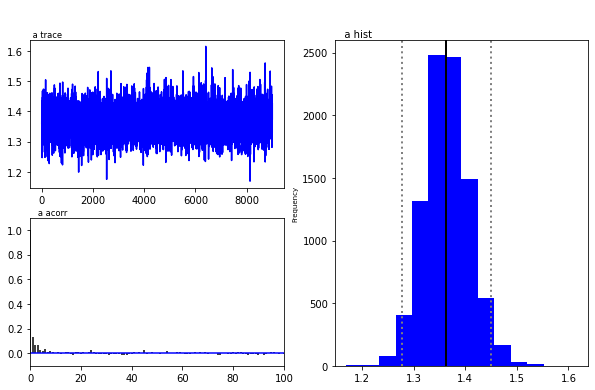

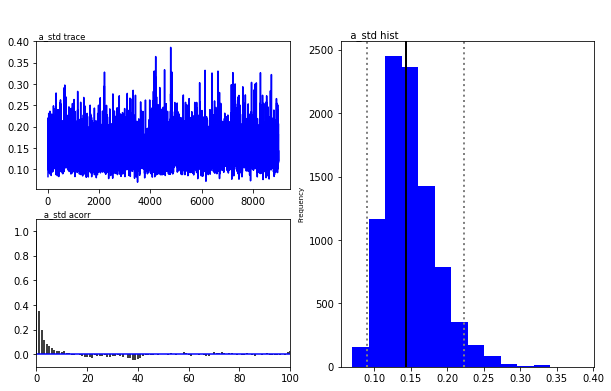

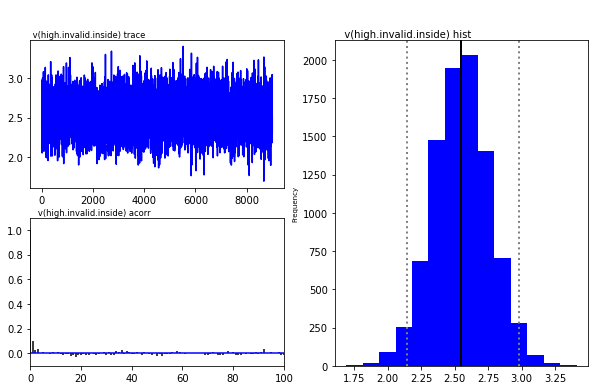

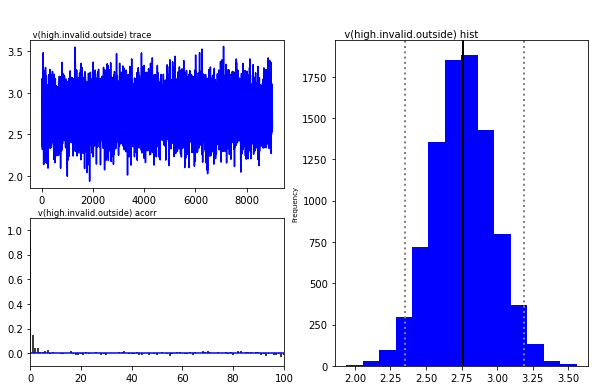

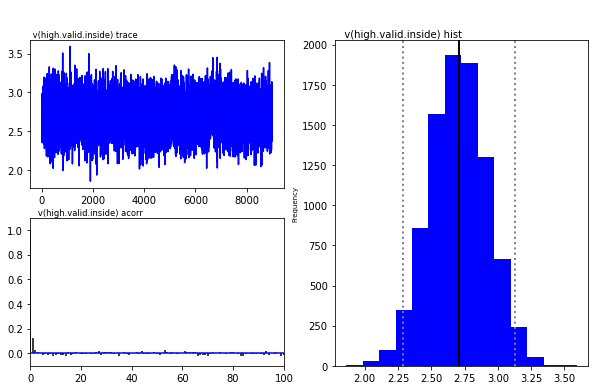

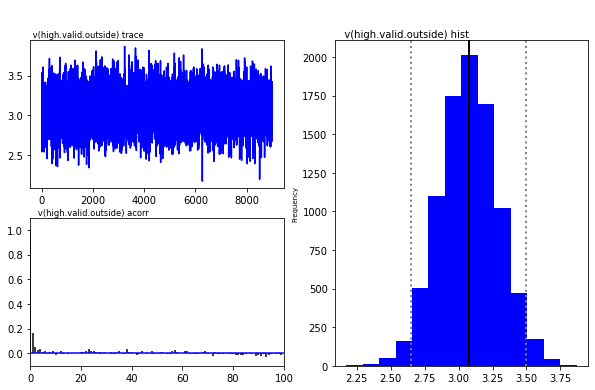

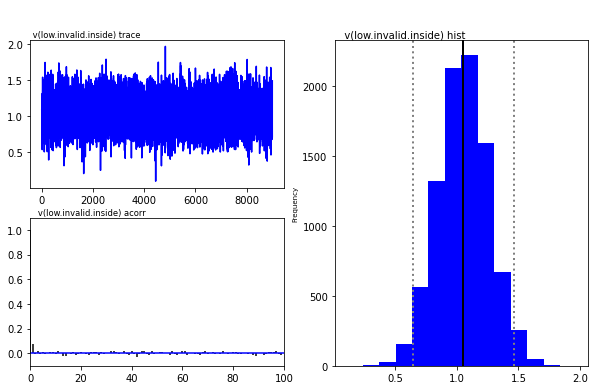

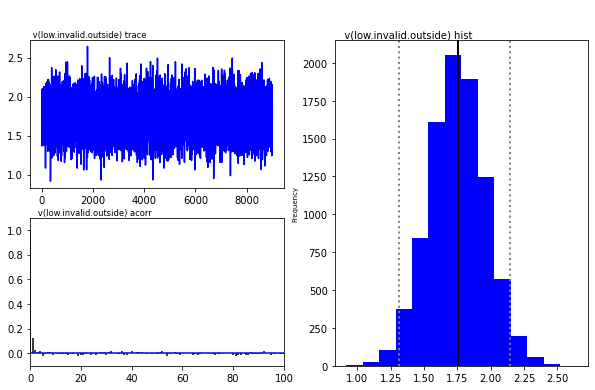

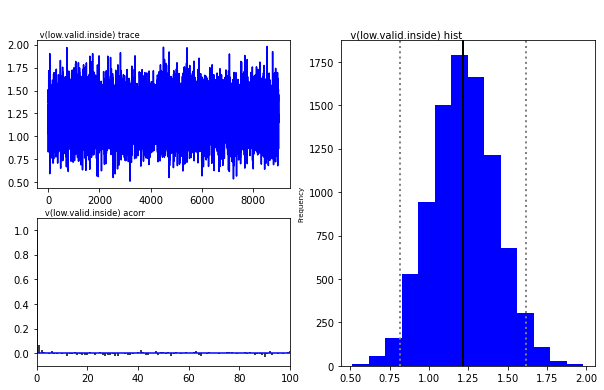

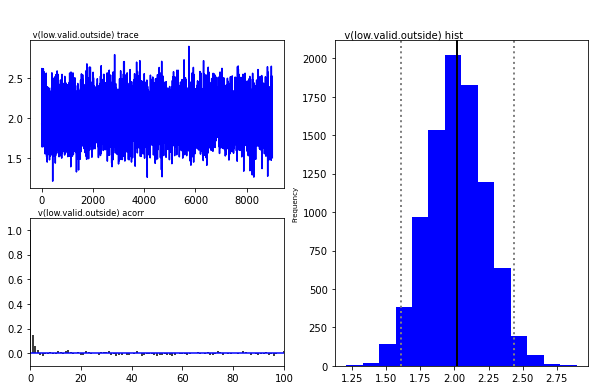

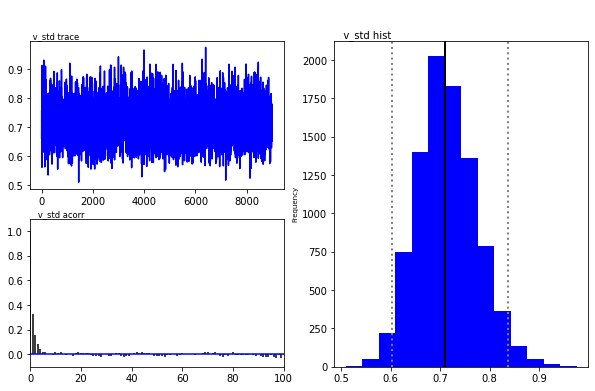

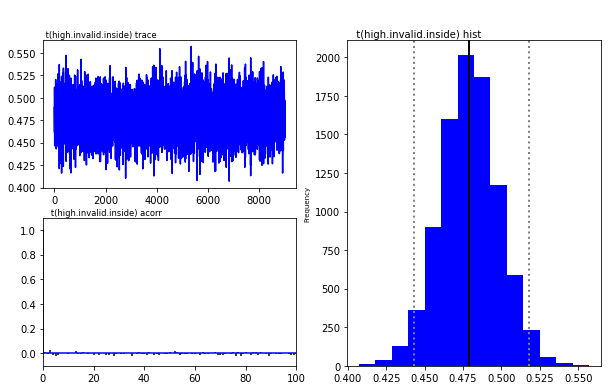

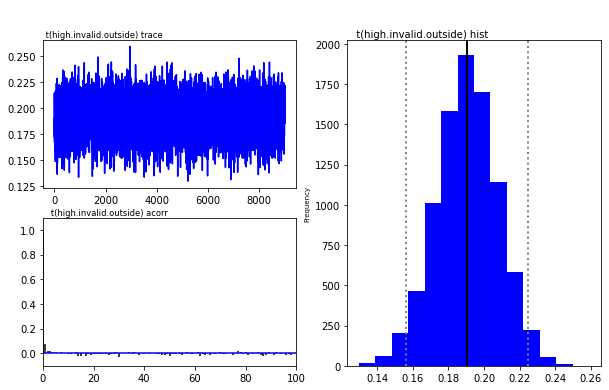

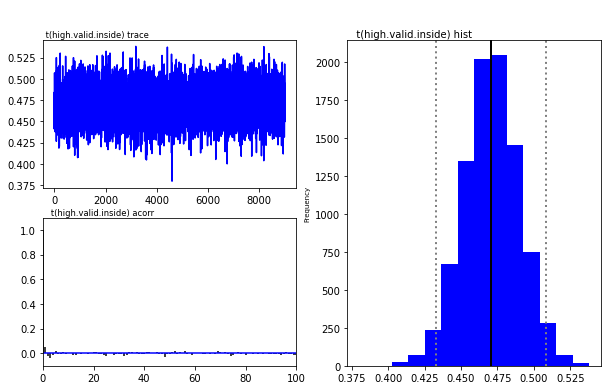

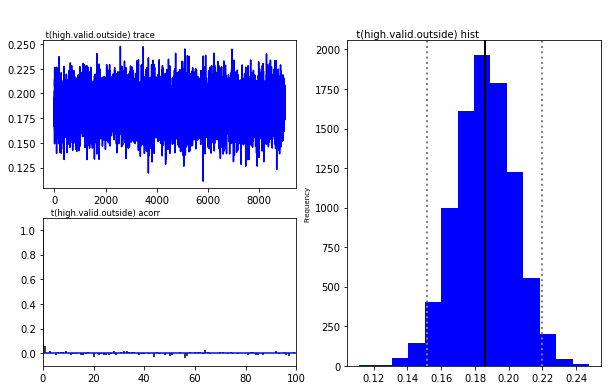

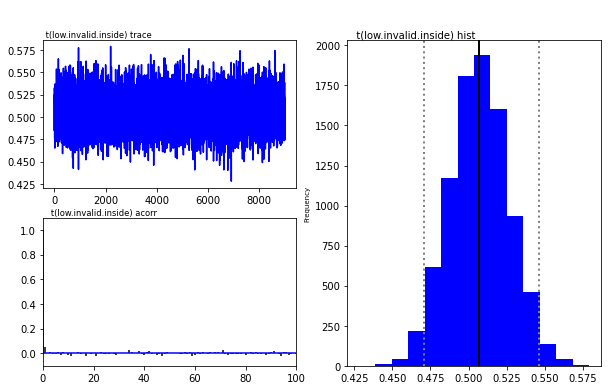

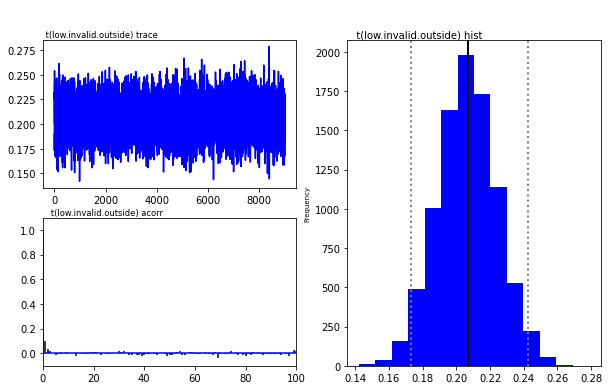

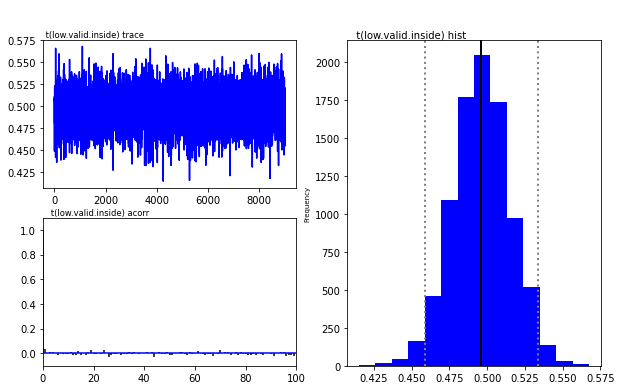

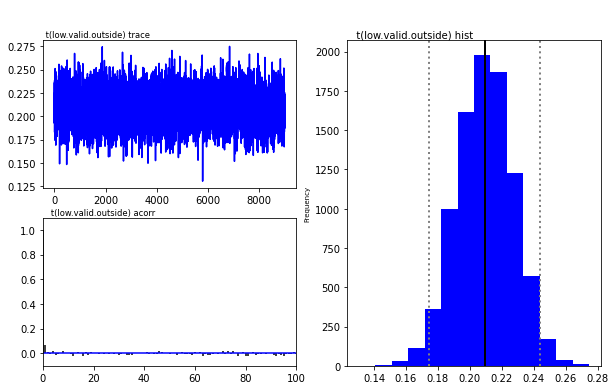

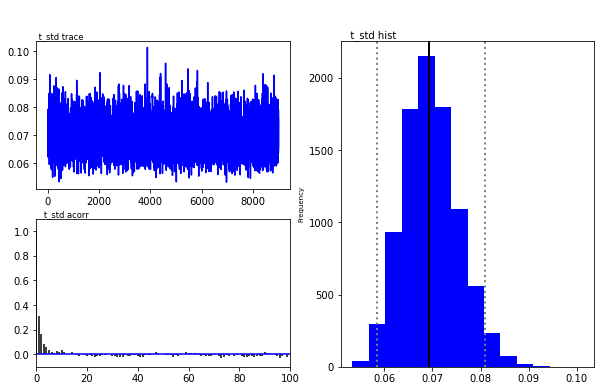

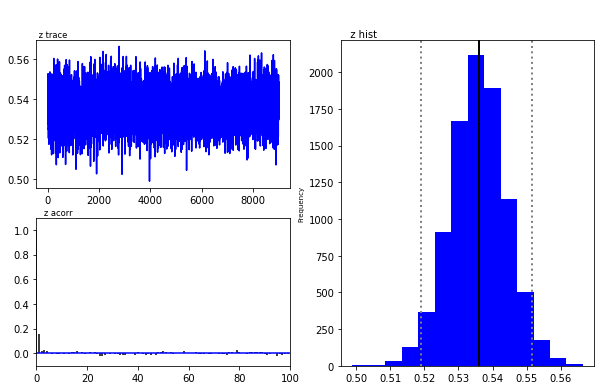

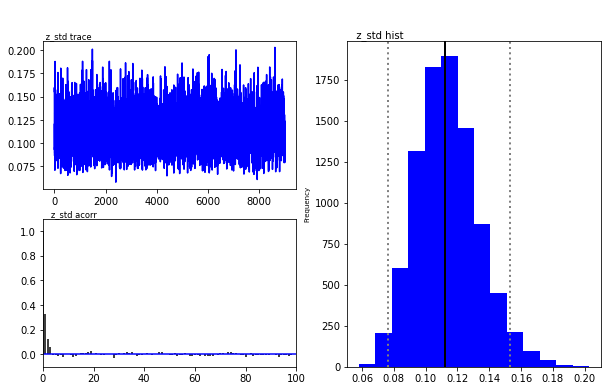

In [6]:
## check convergence of this Chain
M1.plot_posteriors()

Check the model fitting using PPC and DIC:

In [7]:
start_time = time.time()  # the start time of the processing

## calculate the posterior preditive check (ppc)
ppc_data_match_vtz_s = hddm.utils.post_pred_gen(M_match_vtz_s)
ppc_compare_match_vtz_s = hddm.utils.post_pred_stats(dat_M_match, ppc_data_match_vtz_s)  # MSE 
ppc_compare_match_vtz_s.to_csv('ppc_compare_match_vtz_s.csv', sep = ',')

#M_Categ_val_vtz_s.plot_posterior_predictive()  # plot the posterior predictive for each condition of each subject.

## plot the posterior for each condition
# M_match_vatz.plot_posterior_quantiles()
# M_match_vatz.plot_posteriors_conditions()
# M_match_vatz_data =  M_match_vatz.gen_stats

## print the time used for modelling
m1_time = time.time() # the start time of the processing
print("Running PPC of M1 used: %f seconds" % (m1_time - start_time))

 [-----------------100%-----------------] 339 of 336 complete in 4664.7 secRunning PPC of M1 used: 5096.700998 seconds


#### Get results, plot the posteriors, and compare the posteriors.

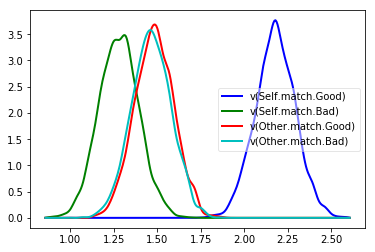

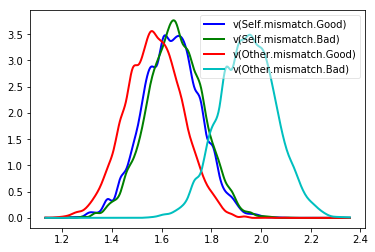

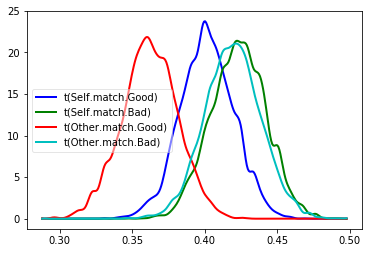

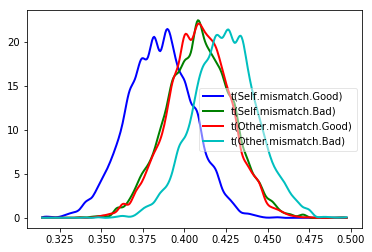

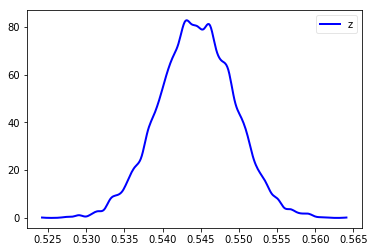

In [10]:
## drift rate
v_GoodSelf_val,v_BadSelf_val, v_GoodOther_val, v_BadOther_val, v_GoodSelf_val_nm,v_BadSelf_val_nm, v_GoodOther_val_nm, v_BadOther_val_nm  = M_match_vtz_s.nodes_db.node[['v(Self.match.Good)',
'v(Self.match.Bad)','v(Other.match.Good)','v(Other.match.Bad)','v(Self.mismatch.Good)','v(Self.mismatch.Bad)','v(Other.mismatch.Good)','v(Other.mismatch.Bad)']]
hddm.analyze.plot_posterior_nodes([v_GoodSelf_val,v_BadSelf_val, v_GoodOther_val, v_BadOther_val])
plt.savefig('ex7_rep_match_vtz_s_v3_m.pdf')

hddm.analyze.plot_posterior_nodes([v_GoodSelf_val_nm,v_BadSelf_val_nm, v_GoodOther_val_nm, v_BadOther_val_nm])
plt.savefig('ex7_rep_match_vtz_s_v3_nm.pdf')

## non-decision time
t_GoodSelf_val,t_BadSelf_val, t_GoodOther_val, t_BadOther_val, t_GoodSelf_val_nm,t_BadSelf_val_nm, t_GoodOther_val_nm, t_BadOther_val_nm  = M_match_vtz_s.nodes_db.node[['t(Self.match.Good)',
't(Self.match.Bad)','t(Other.match.Good)','t(Other.match.Bad)','t(Self.mismatch.Good)','t(Self.mismatch.Bad)','t(Other.mismatch.Good)','t(Other.mismatch.Bad)']]
hddm.analyze.plot_posterior_nodes([t_GoodSelf_val,t_BadSelf_val, t_GoodOther_val, t_BadOther_val])
plt.savefig('ex7_rep_match_vtz_s_t_3_m.pdf')

hddm.analyze.plot_posterior_nodes([t_GoodSelf_val_nm,t_BadSelf_val_nm, t_GoodOther_val_nm, t_BadOther_val_nm])
plt.savefig('ex7_rep_match_vtz_s_t_3_nm.pdf')

## starting point
z_m = M_match_vtz_s.nodes_db.node['z']
hddm.analyze.plot_posterior_nodes([z_m])
plt.savefig('ex7_rep_match_vtz_z_match_plot.pdf')

In [11]:
## uncomment the code below to plot and save the posterior predictions for each subject.
# M_match_vtz_s.plot_posterior_predictive()
# plt.savefig('ex7_rep_match_z_s_pp_plot.pdf')

In [12]:
## using absolute value for "bad" conditions 
print("P(v_M_GoodSelf  > v_M_BadSelf)    = ", (v_GoodSelf_val.trace()  > v_BadSelf_val.trace()).mean())      # 1
print("P(v_M_GoodOther > v_M_BadOther)   = ", (v_GoodOther_val.trace() > v_BadOther_val.trace()).mean())     # 0.5334
print("P(v_M_GoodSelf  > v_M_GoodOther)  = ", (v_GoodSelf_val.trace()  > v_GoodOther_val.trace()).mean())    # 1
print("P(v_M_BadSelf   > v_M_BadOther)   = ", (v_BadSelf_val.trace()   > v_BadOther_val.trace()).mean())     # 0.1227
print("P(v_M_GoodSelf  > v_NM_BadSOther) = ", (v_GoodSelf_val.trace()  > v_BadOther_val_nm.trace()).mean())  # 0.917 

# using absolute value for "bad" conditions 
print("P(t_M_GoodSelf  > t_M_BadSelf)   = ", (t_GoodSelf_val.trace()  > t_BadSelf_val.trace()).mean())       # 0.9984
print("P(t_M_GoodOther > t_M_BadOther)  = ", (t_GoodOther_val.trace() > t_BadOther_val.trace()).mean())      # 0.081
print("P(t_M_GoodSelf  > t_M_GoodOther) = ", (t_GoodSelf_val.trace()  > t_GoodOther_val.trace()).mean())     # 0.995
print("P(t_M_BadSelf   > t_M_BadOther)  = ", (t_BadSelf_val.trace()   > t_BadOther_val.trace()).mean())      # 0.037

print("P(z > 0.05) = ", (z_m.trace() > 0.5).mean()) # 1.0

P(v_M_GoodSelf  > v_M_BadSelf)    =  1.0
P(v_M_GoodOther > v_M_BadOther)   =  0.543111111111
P(v_M_GoodSelf  > v_M_GoodOther)  =  1.0
P(v_M_BadSelf   > v_M_BadOther)   =  0.125111111111
P(v_M_GoodSelf  > v_NM_BadSOther) =  0.922222222222
P(t_M_GoodSelf  > t_M_BadSelf)   =  0.209222222222
P(t_M_GoodOther > t_M_BadOther)  =  0.0156666666667
P(t_M_GoodSelf  > t_M_GoodOther) =  0.933222222222
P(t_M_BadSelf   > t_M_BadOther)  =  0.557111111111
P(z > 0.05) =  1.0


#### Check the convergence of MCMC

In [13]:
# doing Gelman-Rubin statistic (time consuming)
models_match = []
for i in range(4):
    print('processing Model ', i, '\n')
    m_stim = hddm.HDDMStimCoding(dat_M_match,
                                 include='z', 
                                 stim_col='stim',
                                 depends_on={'v':['match','val','id'], 't':['match','val','id']},
                                 split_param='v',
                                 drift_criterion=False)
    
    m_stim.find_starting_values()
    m_stim.sample(nsample, burn = nburn)
    models_match.append(m_stim)

Match_R_hat_vtz = hddm.analyze.gelman_rubin(models_match)

# save Categ_R_hat_vtz
with open('Match_R_hat_vtz_stim.csv','w') as f:
    w = csv.writer(f)
    w.writerows(Match_R_hat_vtz.items())
    

processing Model  0 

 [-----------------100%-----------------] 10000 of 10000 complete in 7675.3 secprocessing Model  1 

 [-----------------100%-----------------] 10001 of 10000 complete in 5966.8 secprocessing Model  2 

 [-----------------100%-----------------] 10001 of 10000 complete in 6437.5 secprocessing Model  3 

 [-----------------100%-----------------] 10001 of 10000 complete in 6151.6 sec